In [ ]:
!pip install --upgrade sympy


In [ ]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the trained model
def load_model(model_path, device):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Extract metadata
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']

    # Load the pre-trained ResNet50 model
    model = models.resnet50(pretrained=False)

    # Dynamically rebuild the fully connected layer to match the saved model
    num_features = model.fc.in_features
    fc_layers = checkpoint['fc_structure']
    layers = []
    input_size = num_features

    for layer in fc_layers:
        if layer["type"] == "Linear":
            layers.append(nn.Linear(input_size, layer["output_size"]))
            input_size = layer["output_size"]
        elif layer["type"] == "ReLU":
            layers.append(nn.ReLU())
        elif layer["type"] == "Dropout":
            layers.append(nn.Dropout(layer["p"]))
    model.fc = nn.Sequential(*layers)

    # Load state_dict into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names


In [ ]:
# Preprocess the input image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device), image


In [ ]:
# Predict the class of the image with fallback mechanism
def predict_with_fallback(image_tensor, model, class_names, class_prices, confidence_threshold=0.6):
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_three_probs, top_three_indices = torch.topk(probabilities, 3, dim=1)
        top_classes = [class_names[idx.item()] for idx in top_three_indices[0]]
        top_probabilities = top_three_probs[0]

        # Check if the highest confidence is above the threshold
        if top_probabilities[0].item() >= confidence_threshold:
            return top_classes[0], class_prices[top_classes[0]], top_probabilities[0].item()

        # Fallback to the cheapest among the top three
        cheapest_class = min(top_classes, key=lambda cls: class_prices[cls])
        return cheapest_class, class_prices[cheapest_class], top_probabilities[0].item()


In [35]:
# Generate a receipt for all images in a folder
def classify_folder_and_generate_receipt(folder_path, model, class_names, class_prices, device, confidence_threshold=0.3):
    receipt = {}
    total_cost = 0.0
    images_to_plot = []

    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if file_name.endswith(('.jpg', '.jpeg', '.png')):  # Ensure it's an image file
            image_tensor, image = preprocess_image(image_path, device)
            predicted_class, price, confidence = predict_with_fallback(
                image_tensor, model, class_names, class_prices, confidence_threshold
            )

            # Add to receipt
            if predicted_class in receipt:
                receipt[predicted_class]['quantity'] += 1
                receipt[predicted_class]['cost'] += price
            else:
                receipt[predicted_class] = {'quantity': 1, 'cost': price}

            total_cost += price
            print(f"Classified {file_name} as {predicted_class} (${price:.2f}, Confidence: {confidence:.2f})")

            # Save image and prediction for visualization
            images_to_plot.append((image, predicted_class, price, confidence))

    # Print receipt
    print("\n--- Receipt ---")
    for item, details in receipt.items():
        print(f"{item}: {details['quantity']} @ ${details['cost'] / details['quantity']:.2f} = ${details['cost']:.2f}")
    print(f"Total: ${total_cost:.2f}")

    # Visualize predictions
    plot_predictions(images_to_plot)

In [ ]:
# Plot images with predictions
def plot_predictions(images_to_plot):
    plt.figure(figsize=(15, 10))
    for idx, (image, predicted_class, price, confidence) in enumerate(images_to_plot[:9]):  # Show up to 9 images
        plt.subplot(3, 3, idx + 1)
        plt.imshow(image)
        plt.title(f"{predicted_class}\nPrice: ${price:.2f}, Conf: {confidence:.2f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



Device: cpu


<ipython-input-20-c1a83d0c5124>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Classified Copy of Image_3 (1).jpg as eggplant ($1.50, Confidence: 1.00)
Classified Copy of Image_3.jpg as banana ($0.62, Confidence: 1.00)
Classified Copy of Image_2 (1).jpg as grapes ($2.67, Confidence: 1.00)
Classified Copy of Image_2.jpg as apple ($1.39, Confidence: 1.00)
Classified Copy of Image_4.jpg as corn ($0.50, Confidence: 0.84)
Classified Copy of Image_5.jpg as turnip ($1.00, Confidence: 1.00)

--- Receipt ---
eggplant: 1 @ $1.50 = $1.50
banana: 1 @ $0.62 = $0.62
grapes: 1 @ $2.67 = $2.67
apple: 1 @ $1.39 = $1.39
corn: 1 @ $0.50 = $0.50
turnip: 1 @ $1.00 = $1.00
Total: $7.68


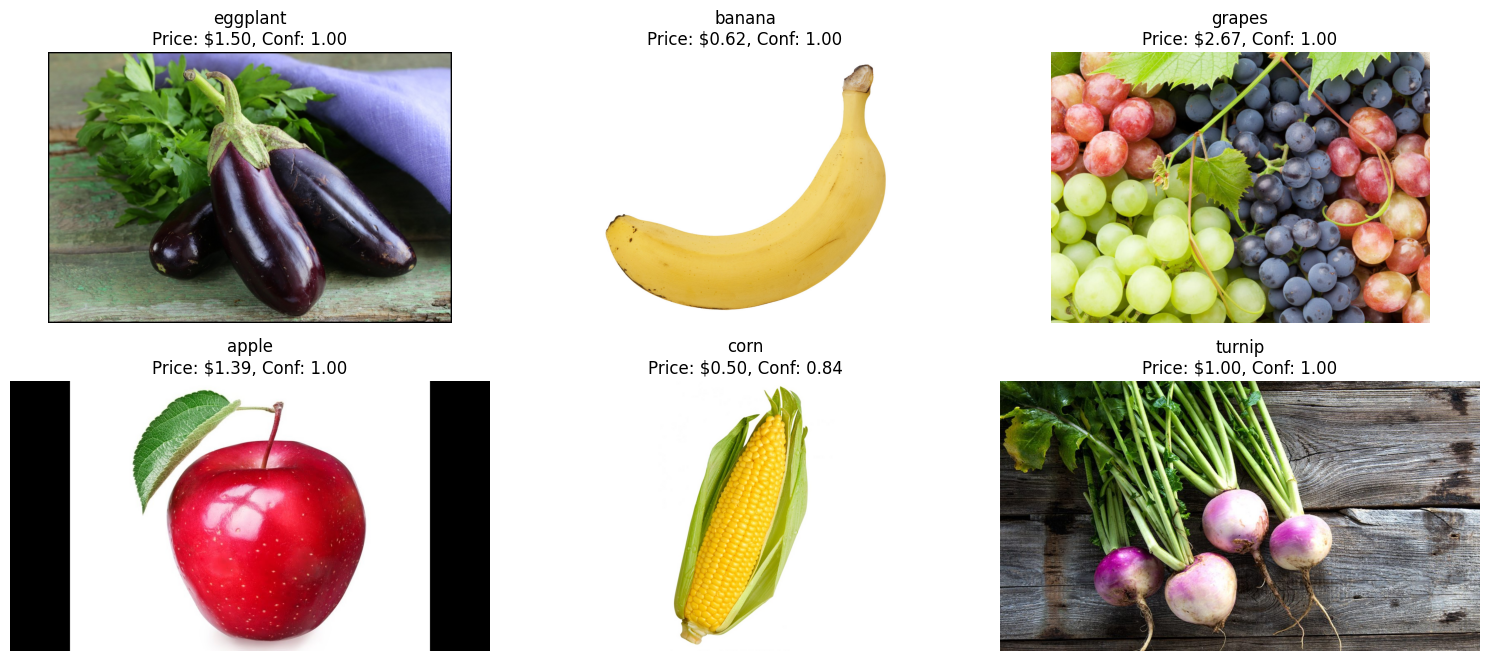

In [37]:
# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Define hardcoded paths
    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Replace with your model path
    folder_path = '/content/drive/My Drive/modeltest/ShoppingCart'  # Replace with your folder path

    # Price dictionary for fruits and vegetables
    class_prices = {
    "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
    "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
    "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
    "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
    "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
    "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
    "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
    "watermelon": 0.32}


    # Load the model and class names
    model, class_names = load_model(model_path, device)

    # Classify images in the folder and generate receipt
    classify_folder_and_generate_receipt(folder_path, model, class_names, class_prices, device, confidence_threshold=0.8)


if __name__ == "__main__":
    main()


Device: cpu


<ipython-input-20-c1a83d0c5124>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Classified Copy of Corn.jpeg as corn ($0.50, Confidence: 0.67)
Classified Copy of Banana.jpeg as banana ($0.62, Confidence: 0.72)
Classified Copy of Lemon.jpeg as onion ($0.92, Confidence: 0.81)
Classified Copy of Grapes.jpeg as onion ($0.92, Confidence: 0.36)
Classified Copy of Garlic.jpeg as garlic ($2.00, Confidence: 0.99)
Classified Copy of Carrot.jpeg as carrot ($0.74, Confidence: 0.95)

--- Receipt ---
corn: 1 @ $0.50 = $0.50
banana: 1 @ $0.62 = $0.62
onion: 2 @ $0.92 = $1.84
garlic: 1 @ $2.00 = $2.00
carrot: 1 @ $0.74 = $0.74
Total: $5.70


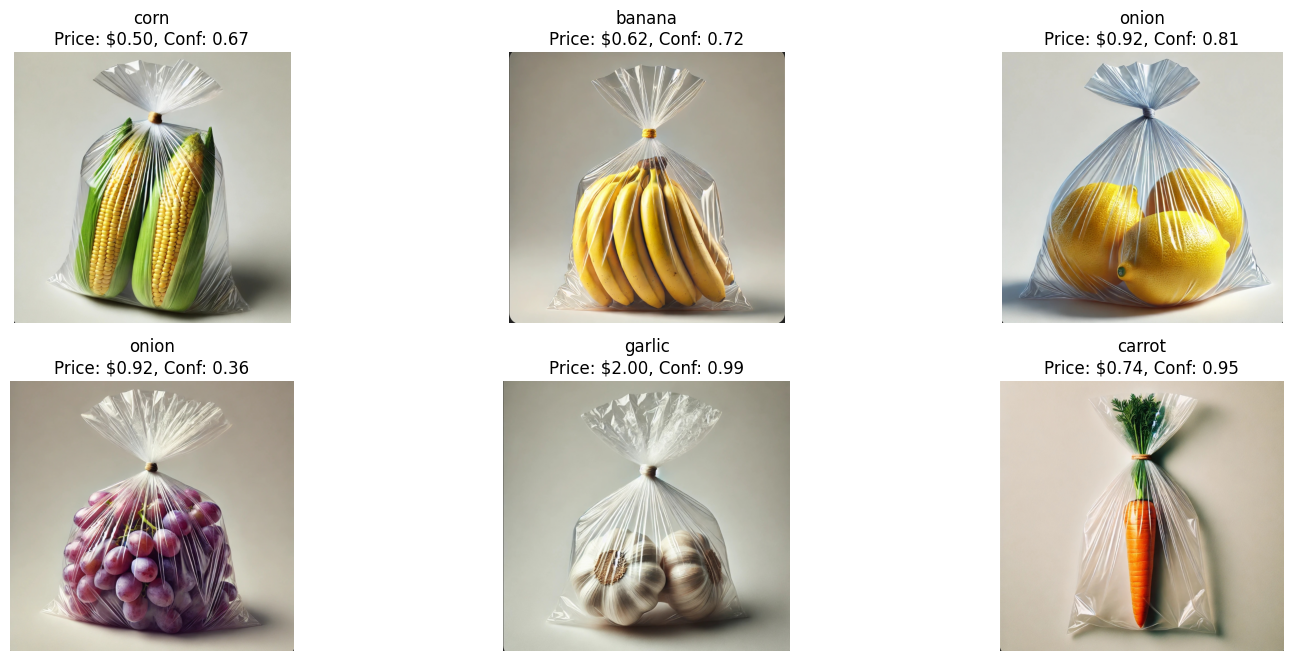

In [40]:
# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Define hardcoded paths
    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Replace with your model path
    folder_path = '/content/drive/My Drive/modeltest/SC2'  # Replace with your folder path

    # Price dictionary for fruits and vegetables
    class_prices = {
    "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
    "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
    "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
    "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
    "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
    "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
    "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
    "watermelon": 0.32}


    # Load the model and class names
    model, class_names = load_model(model_path, device)

    # Classify images in the folder and generate receipt
    classify_folder_and_generate_receipt(folder_path, model, class_names, class_prices, device, confidence_threshold=0.8)


if __name__ == "__main__":
    main()


Device: cpu


<ipython-input-20-c1a83d0c5124>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Classified Copy of Corn.jpeg as corn ($0.50, Confidence: 0.67)
Classified Copy of Banana.jpeg as banana ($0.62, Confidence: 0.72)
Classified Copy of Lemon.jpeg as onion ($0.92, Confidence: 0.81)
Classified Copy of Grapes.jpeg as garlic ($2.00, Confidence: 0.36)
Classified Copy of Garlic.jpeg as garlic ($2.00, Confidence: 0.99)
Classified Copy of Carrot.jpeg as carrot ($0.74, Confidence: 0.95)

--- Receipt ---
corn: 1 @ $0.50 = $0.50
banana: 1 @ $0.62 = $0.62
onion: 1 @ $0.92 = $0.92
garlic: 2 @ $2.00 = $4.00
carrot: 1 @ $0.74 = $0.74
Total: $6.78


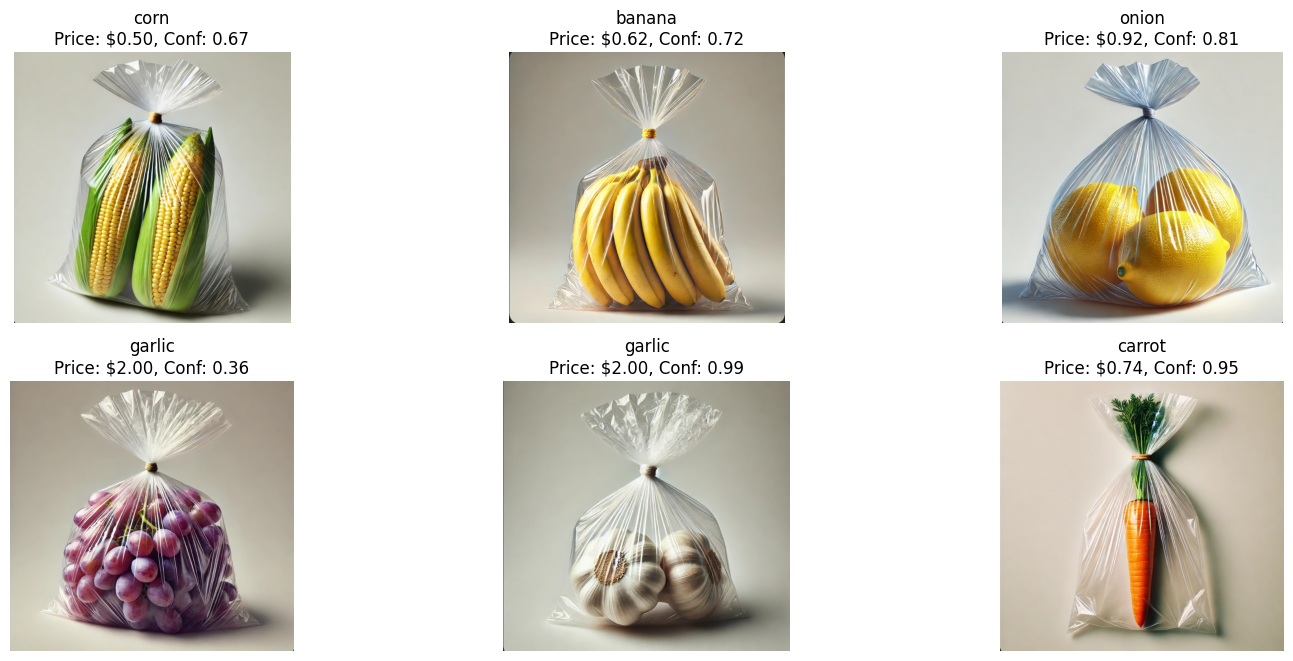

In [39]:
# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Define hardcoded paths
    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Replace with your model path
    folder_path = '/content/drive/My Drive/modeltest/SC2'  # Replace with your folder path

    # Price dictionary for fruits and vegetables
    class_prices = {
    "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
    "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
    "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
    "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
    "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
    "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
    "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
    "watermelon": 0.32}


    # Load the model and class names
    model, class_names = load_model(model_path, device)

    # Classify images in the folder and generate receipt
    classify_folder_and_generate_receipt(folder_path, model, class_names, class_prices, device, confidence_threshold=0.3)


if __name__ == "__main__":
    main()


Device: cpu


<ipython-input-8-4ef36df090d4>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


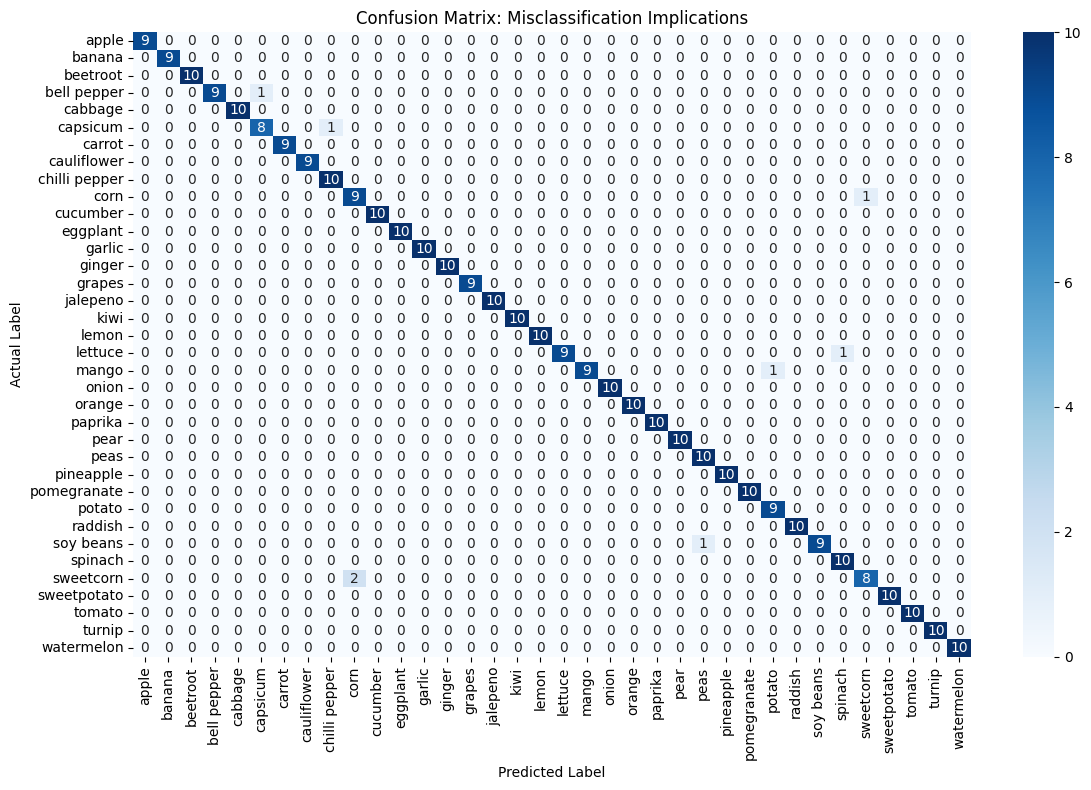


--- Financial Loss Report ---
Customer Loss (Overcharges): $2.51
Store Loss (Undercharges): $1.08


In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from torchvision import transforms, models

# Define paths
folder_path = '/content/drive/My Drive/fruittest'  # Update with your fruittest folder path
model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Update with your trained model path

# Price dictionary for fruits and vegetables
class_prices = {
    "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
    "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
    "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
    "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
    "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
    "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
    "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
    "watermelon": 0.32
}

# Load the model
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']

    model = models.resnet50(pretrained=False)
    num_features = model.fc.in_features
    fc_layers = checkpoint['fc_structure']
    layers = []
    input_size = num_features
    for layer in fc_layers:
        if layer["type"] == "Linear":
            layers.append(torch.nn.Linear(input_size, layer["output_size"]))
            input_size = layer["output_size"]
        elif layer["type"] == "ReLU":
            layers.append(torch.nn.ReLU())
        elif layer["type"] == "Dropout":
            layers.append(torch.nn.Dropout(layer["p"]))
    model.fc = torch.nn.Sequential(*layers)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names

# Preprocess the image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

# Perform predictions and calculate losses
def evaluate_fruittest(folder_path, model, class_names, class_prices, device):
    predictions = []
    actuals = []
    customer_loss = 0.0
    store_loss = 0.0

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, file_name)
                    image_tensor = preprocess_image(image_path, device)

                    # Predict the class
                    with torch.no_grad():
                        outputs = model(image_tensor)
                        predicted_idx = outputs.argmax(dim=1).item()
                        predicted_class = class_names[predicted_idx]

                    # Store predictions and actuals
                    predictions.append(predicted_idx)
                    actuals.append(class_names.index(class_folder))

                    # Calculate financial implications
                    actual_price = class_prices[class_folder]
                    predicted_price = class_prices[predicted_class]
                    if predicted_price > actual_price:  # Overcharge (Customer Loss)
                        customer_loss += (predicted_price - actual_price)
                    elif predicted_price < actual_price:  # Undercharge (Store Loss)
                        store_loss += (actual_price - predicted_price)

    return predictions, actuals, customer_loss, store_loss

# Plot confusion matrix
def plot_confusion_matrix(actuals, predictions, class_names):
    cm = confusion_matrix(actuals, predictions, labels=range(len(class_names)))
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix: Misclassification Implications")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Load model and class names
    model, class_names = load_model(model_path, device)

    # Evaluate on fruittest and calculate losses
    predictions, actuals, customer_loss, store_loss = evaluate_fruittest(
        folder_path, model, class_names, class_prices, device
    )

    # Display confusion matrix
    plot_confusion_matrix(actuals, predictions, class_names)

    # Print financial loss report
    print("\n--- Financial Loss Report ---")
    print(f"Customer Loss (Overcharges): ${customer_loss:.2f}")
    print(f"Store Loss (Undercharges): ${store_loss:.2f}")

if __name__ == "__main__":
    main()


In [ ]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import torch.nn.functional as F
from google.colab import drive
from sklearn.metrics import confusion_matrix
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Load the trained model
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']

    # Load the pre-trained ResNet50 model
    model = models.resnet50(pretrained=False)
    num_features = model.fc.in_features
    fc_layers = checkpoint['fc_structure']
    layers = []
    input_size = num_features

    for layer in fc_layers:
        if layer["type"] == "Linear":
            layers.append(torch.nn.Linear(input_size, layer["output_size"]))
            input_size = layer["output_size"]
        elif layer["type"] == "ReLU":
            layers.append(torch.nn.ReLU())
        elif layer["type"] == "Dropout":
            layers.append(torch.nn.Dropout(layer["p"]))
    model.fc = torch.nn.Sequential(*layers)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names

# Preprocess the input image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# Calculate financial losses after fallback
def calculate_loss_after_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.6):
    total_loss = 0.0
    total_cost = 0.0
    total_items = 0

    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            image_tensor = preprocess_image(image_path, device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = F.softmax(outputs, dim=1)
                top_three_probs, top_three_indices = torch.topk(probabilities, 3, dim=1)
                top_classes = [class_names[idx.item()] for idx in top_three_indices[0]]
                top_probabilities = top_three_probs[0]

                # Determine the fallback class
                highest_confidence_class = top_classes[0]
                highest_confidence_price = class_prices[highest_confidence_class]

                if top_probabilities[0].item() >= confidence_threshold:
                    final_class = highest_confidence_class
                    final_price = highest_confidence_price
                else:
                    final_class = min(top_classes, key=lambda cls: class_prices[cls])
                    final_price = class_prices[final_class]

                # Calculate loss
                loss = highest_confidence_price - final_price if final_class != highest_confidence_class else 0.0
                total_loss += loss
                total_cost += final_price
                total_items += 1

                print(f"Image: {file_name}")
                print(f"Highest-confidence: {highest_confidence_class} (${highest_confidence_price:.2f}, Confidence: {top_probabilities[0].item():.2f})")
                print(f"Final prediction: {final_class} (${final_price:.2f})")
                print(f"Loss: ${loss:.2f}" if loss > 0 else "No loss")
                print("-" * 50)

    print("\n--- Financial Summary After Fallback ---")
    print(f"Total cost (after fallback): ${total_cost:.2f}")
    print(f"Total financial loss (after fallback): ${total_loss:.2f}")
    print(f"Total items classified: {total_items}")
    return total_cost, total_loss

# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'
    folder_path = '/content/drive/My Drive/fruittest'

    class_prices = {
        "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
        "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
        "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
        "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
        "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
        "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
        "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
        "watermelon": 0.32,
    }

    model, class_names = load_model(model_path, device)
    calculate_loss_after_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.6)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu


<ipython-input-10-febd46fce2fc>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



--- Financial Summary After Fallback ---
Total cost (after fallback): $0.00
Total financial loss (after fallback): $0.00
Total items classified: 0


In [ ]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import torch.nn.functional as F
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the trained model
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']

    # Load the pre-trained ResNet50 model
    model = models.resnet50(pretrained=False)
    num_features = model.fc.in_features
    fc_layers = checkpoint['fc_structure']
    layers = []
    input_size = num_features

    for layer in fc_layers:
        if layer["type"] == "Linear":
            layers.append(torch.nn.Linear(input_size, layer["output_size"]))
            input_size = layer["output_size"]
        elif layer["type"] == "ReLU":
            layers.append(torch.nn.ReLU())
        elif layer["type"] == "Dropout":
            layers.append(torch.nn.Dropout(layer["p"]))
    model.fc = torch.nn.Sequential(*layers)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names

# Preprocess the input image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# Calculate financial losses after fallback
def calculate_loss_after_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.99):
    total_loss = 0.0
    total_cost = 0.0
    total_items = 0

    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            image_tensor = preprocess_image(image_path, device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = F.softmax(outputs, dim=1)
                top_three_probs, top_three_indices = torch.topk(probabilities, 3, dim=1)
                top_classes = [class_names[idx.item()] for idx in top_three_indices[0]]
                top_probabilities = top_three_probs[0]

                # Debug: Check predictions and confidence
                print(f"Image: {file_name}")
                print(f"Top Classes: {top_classes}")
                print(f"Top Probabilities: {[prob.item() for prob in top_probabilities]}")

                # Determine the fallback class
                highest_confidence_class = top_classes[0]
                highest_confidence_price = class_prices[highest_confidence_class]

                if top_probabilities[0].item() >= confidence_threshold:
                    final_class = highest_confidence_class
                    final_price = highest_confidence_price
                else:
                    final_class = min(top_classes, key=lambda cls: class_prices[cls])
                    final_price = class_prices[final_class]

                # Calculate loss
                loss = highest_confidence_price - final_price if final_class != highest_confidence_class else 0.0
                total_loss += loss
                total_cost += final_price
                total_items += 1

                # Debug: Check fallback decision
                print(f"Highest-confidence: {highest_confidence_class} (${highest_confidence_price:.2f}, Confidence: {top_probabilities[0].item():.2f})")
                print(f"Final prediction: {final_class} (${final_price:.2f})")
                print(f"Loss: ${loss:.2f}" if loss > 0 else "No loss")
                print("-" * 50)

    print("\n--- Financial Summary After Fallback ---")
    print(f"Total cost (after fallback): ${total_cost:.2f}")
    print(f"Total financial loss (after fallback): ${total_loss:.2f}")
    print(f"Total items classified: {total_items}")
    return total_cost, total_loss

# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    folder_path = '/content/drive/My Drive/fruittest'  # Update with your fruittest folder path
    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Update with your trained model path

    class_prices = {
        "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
        "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
        "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
        "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
        "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
        "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
        "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
        "watermelon": 0.32,
    }

    model, class_names = load_model(model_path, device)
    calculate_loss_after_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.99)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu


<ipython-input-14-29e09382be00>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



--- Financial Summary After Fallback ---
Total cost (after fallback): $0.00
Total financial loss (after fallback): $0.00
Total items classified: 0


<ipython-input-14-29e09382be00>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


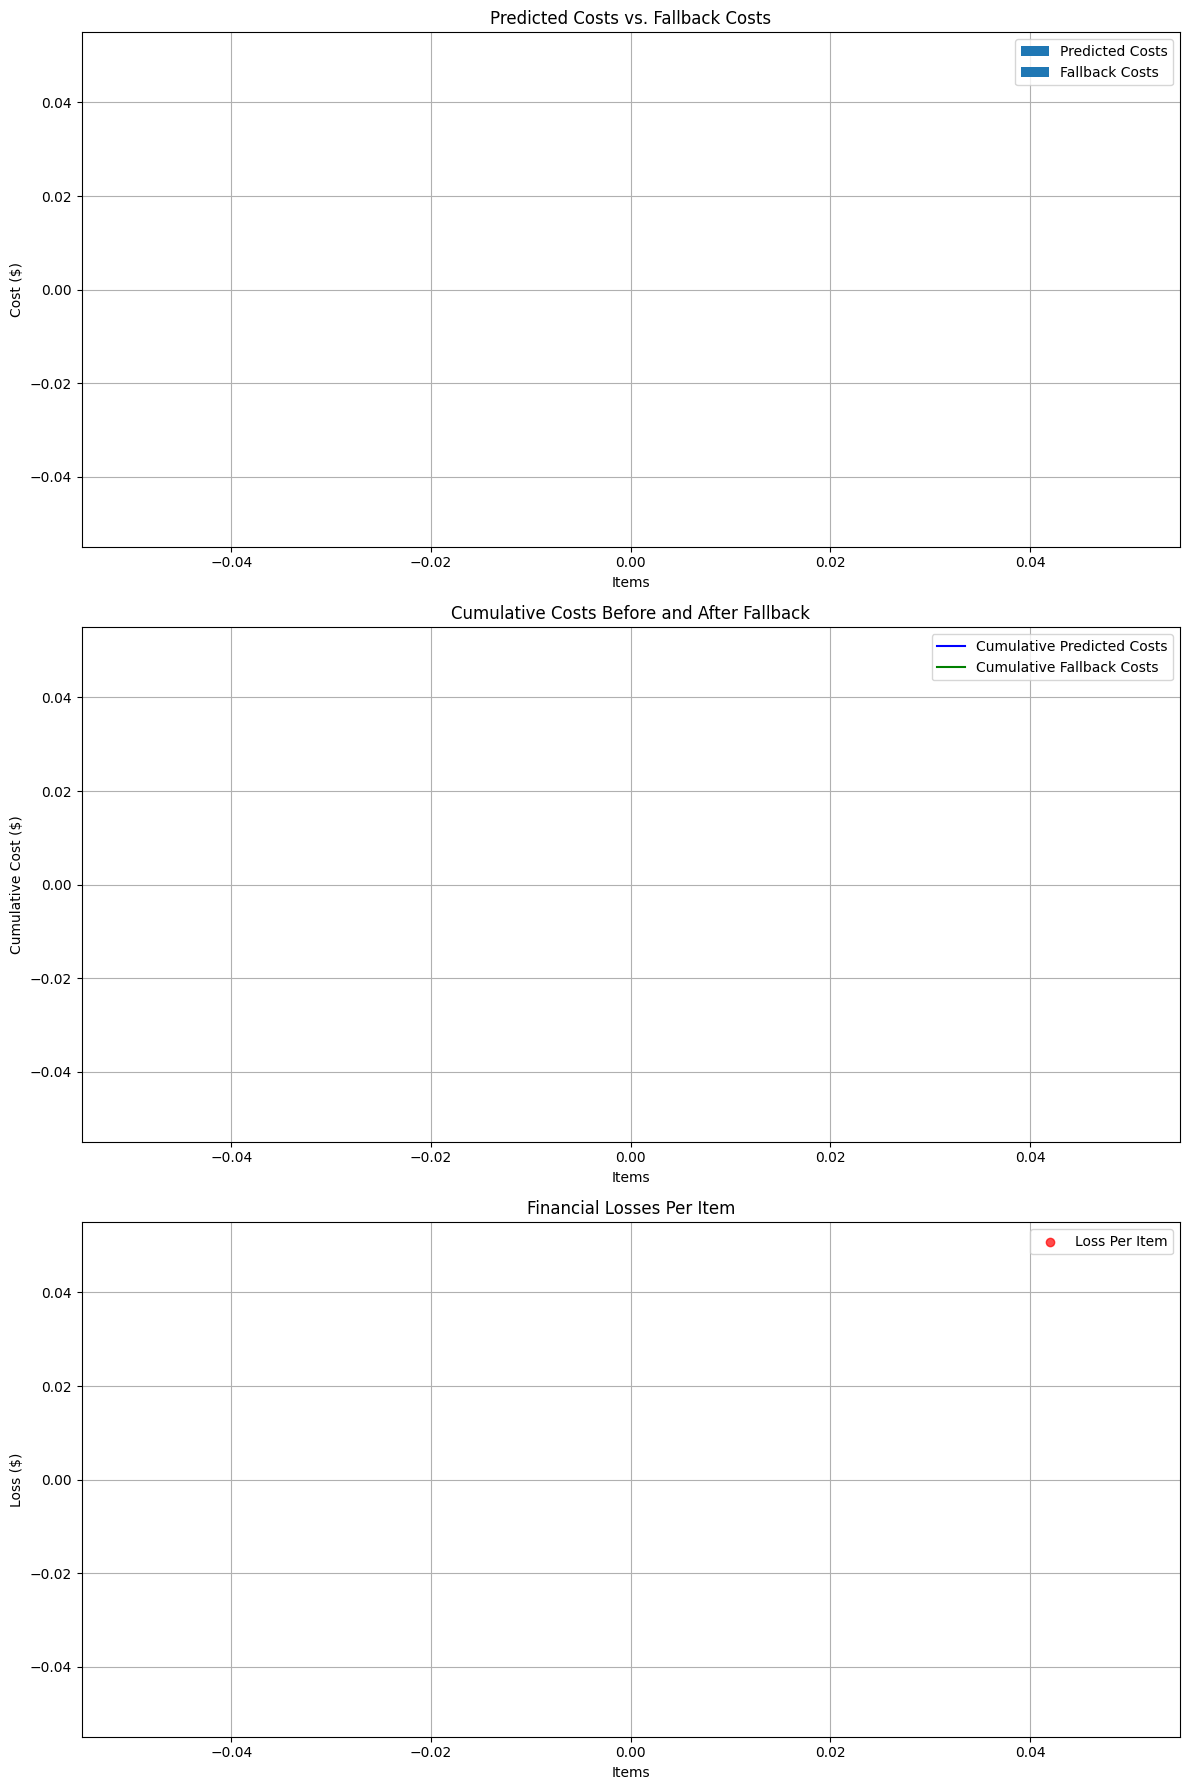


--- Financial Impact Summary ---
Total Loss: $0.00
Total Cost Before Fallback: $0.00
Total Cost After Fallback: $0.00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cost_aware_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.6):
    predicted_costs = []
    fallback_costs = []
    financial_losses = []
    items = []

    for file_idx, file_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, file_name)
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            image_tensor = preprocess_image(image_path, device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = F.softmax(outputs, dim=1)
                top_three_probs, top_three_indices = torch.topk(probabilities, 3, dim=1)
                top_classes = [class_names[idx.item()] for idx in top_three_indices[0]]
                top_probabilities = top_three_probs[0]

                # Determine highest-confidence class and fallback class
                highest_confidence_class = top_classes[0]
                highest_confidence_price = class_prices[highest_confidence_class]

                if top_probabilities[0].item() >= confidence_threshold:
                    fallback_class = highest_confidence_class
                    fallback_price = highest_confidence_price
                else:
                    fallback_class = min(top_classes, key=lambda cls: class_prices[cls])
                    fallback_price = class_prices[fallback_class]

                # Calculate financial loss
                loss = highest_confidence_price - fallback_price if fallback_class != highest_confidence_class else 0.0

                # Append results
                predicted_costs.append(highest_confidence_price)
                fallback_costs.append(fallback_price)
                financial_losses.append(loss)
                items.append(file_idx + 1)

    # Visualizations
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # 1. Bar Chart: Predicted vs. Fallback Costs
    axs[0].bar(items, predicted_costs, label="Predicted Costs", color="blue", alpha=0.7)
    axs[0].bar(items, fallback_costs, label="Fallback Costs", color="green", alpha=0.7)
    axs[0].set_title("Predicted Costs vs. Fallback Costs")
    axs[0].set_xlabel("Items")
    axs[0].set_ylabel("Cost ($)")
    axs[0].legend()
    axs[0].grid()

    # 2. Line Chart: Cumulative Costs
    cumulative_predicted = np.cumsum(predicted_costs)
    cumulative_fallback = np.cumsum(fallback_costs)
    axs[1].plot(items, cumulative_predicted, label="Cumulative Predicted Costs", color="blue")
    axs[1].plot(items, cumulative_fallback, label="Cumulative Fallback Costs", color="green")
    axs[1].set_title("Cumulative Costs Before and After Fallback")
    axs[1].set_xlabel("Items")
    axs[1].set_ylabel("Cumulative Cost ($)")
    axs[1].legend()
    axs[1].grid()

    # 3. Scatter Plot: Financial Losses
    axs[2].scatter(items, financial_losses, label="Loss Per Item", color="red", alpha=0.7)
    axs[2].set_title("Financial Losses Per Item")
    axs[2].set_xlabel("Items")
    axs[2].set_ylabel("Loss ($)")
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

    # Print total financial impact
    total_loss = sum(financial_losses)
    print("\n--- Financial Impact Summary ---")
    print(f"Total Loss: ${total_loss:.2f}")
    print(f"Total Cost Before Fallback: ${sum(predicted_costs):.2f}")
    print(f"Total Cost After Fallback: ${sum(fallback_costs):.2f}")

# Call the function in your main program
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    folder_path = '/content/drive/My Drive/fruittest'  # Update with your fruittest folder path
    model_path = '/content/drive/My Drive/modeltest/resnet-model.pth'  # Update with your trained model path

    class_prices = {
        "apple": 1.39, "banana": 0.62, "beetroot": 1.50, "bell pepper": 1.45, "cabbage": 0.62,
        "capsicum": 1.45, "carrot": 0.74, "cauliflower": 1.98, "chilli pepper": 2.50, "corn": 0.50,
        "cucumber": 0.72, "eggplant": 1.50, "garlic": 2.00, "ginger": 3.00, "grapes": 2.67,
        "jalepeno": 1.50, "kiwi": 2.21, "lemon": 2.05, "lettuce": 1.21, "mango": 1.36,
        "onion": 0.92, "orange": 1.24, "paprika": 2.00, "pear": 1.52, "peas": 1.50,
        "pineapple": 0.99, "pomegranate": 2.08, "potato": 0.78, "raddish": 1.00, "soy beans": 2.00,
        "spinach": 2.67, "sweetcorn": 0.50, "sweetpotato": 0.92, "tomato": 1.84, "turnip": 1.00,
        "watermelon": 0.32,
    }

    model, class_names = load_model(model_path, device)
    visualize_cost_aware_fallback(folder_path, model, class_names, class_prices, device, confidence_threshold=0.6)
